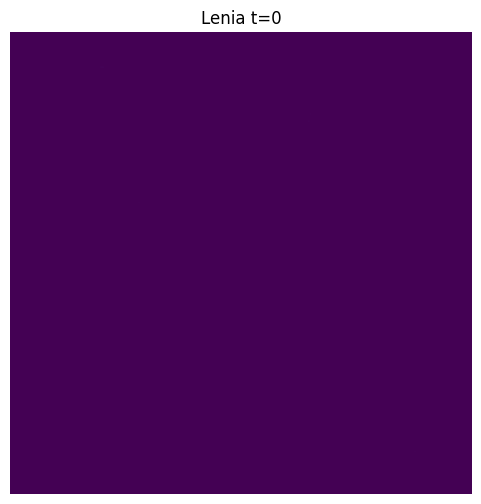

In [3]:
"""
Minimal, self-contained Lenia (discrete + smooth) implementation in Python
-----------------------------------------------------------------------------
Features
- Periodic 2D grid on a torus using FFT-based convolution
- Kernel = shell( beta, B ) ∘ core( r ) with normalization to keep K*A in [0,1]
- Growth function G(u; mu, sigma) with Euler update and clamping to [0,1]
- Clean, modular functions so you can swap kernel cores or shells

No external deps beyond NumPy and Matplotlib (for the demo at bottom).
-----------------------------------------------------------------------------
References (conceptual):
- Lenia kernel core KC(r) unimodal on r∈[0,1], with KC(0)=KC(1)=0, peak near r=1/2
- Kernel shell KS copies the core into B concentric rings with heights β_i
- Kernel normalized so that sum(K) == 1 (discrete Lenia)
"""
from __future__ import annotations
import numpy as np
from dataclasses import dataclass
from typing import Tuple, Literal, Optional

Array = np.ndarray

# ------------------------------- Kernel Core ---------------------------------

def kernel_core(r: Array, core: Literal['exp', 'poly', 'rect'] = 'exp', alpha: float = 4.0) -> Array:
    """Compute KC(r) for r in [0,1], elementwise.
    Conditions: KC(0)=KC(1)=0, unimodal with peak near 1/2.
    - 'exp' : exp(alpha - alpha/(4 r (1-r))) on (0,1), 0 at endpoints.
    - 'poly': (4 r (1-r))**alpha
    - 'rect': 1 on [1/4, 3/4], else 0
    """
    r = np.asarray(r)
    KC = np.zeros_like(r, dtype=float)

    if core == 'exp':
        # Safe compute on (0,1). At endpoints set to 0.
        mask = (r > 0.0) & (r < 1.0)
        rm = r[mask]
        KC[mask] = np.exp(alpha - (alpha / (4.0 * rm * (1.0 - rm))))
        # Values outside (0,1) remain 0.

    elif core == 'poly':
        KC = np.clip(4.0 * r * (1.0 - r), 0.0, None) ** alpha

    elif core == 'rect':
        KC[(r >= 0.25) & (r <= 0.75)] = 1.0

    else:
        raise ValueError(f"Unknown core type: {core}")

    # Normalize so that KC(0)=KC(1)=0 and peak near 1/2 ≈ 1
    # Optional rescale to max 1 (not strictly required, kernel normalization handles global scale)
    maxv = KC.max()
    if maxv > 0:
        KC = KC / maxv
    return KC

# ------------------------------- Kernel Shell --------------------------------

def kernel_shell(r: Array, B: int, beta: Array, core: Literal['exp','poly','rect']='exp', alpha: float=4.0) -> Array:
    """Compute KS(r; beta) by tiling the core into B bands with heights beta[i].
    r in [0,1]. For each r, i = floor(B*r), phase = B*r - i, KS = beta[i] * KC(phase).
    """
    r = np.asarray(r)
    beta = np.asarray(beta, dtype=float)
    assert len(beta) == B, "beta must have length B"

    # Clamp r into [0,1] and drop outside
    r_clamped = np.clip(r, 0.0, 1.0)

    # Compute band index and local phase within band
    # Use np.minimum to keep the highest index at B-1 when r==1
    idx = np.minimum((np.floor(B * r_clamped)).astype(int), B - 1)
    phase = B * r_clamped - idx

    KC = kernel_core(phase, core=core, alpha=alpha)
    KS = beta[idx] * KC
    return KS

# ------------------------------ 2D Kernel Build -------------------------------

def build_kernel(shape: Tuple[int,int], R: float, B: int, beta: Array,
                 core: Literal['exp','poly','rect']='exp', alpha: float=4.0) -> Array:
    """Build a 2D, periodic, normalized kernel K on a torus grid of given shape.

    Parameters
    - shape: (H, W)
    - R: kernel radius in pixels (support is r <= 1 after normalizing by R)
    - B: number of shells (rings)
    - beta: length-B ring amplitudes (will be rescaled implicitly by normalization)

    Returns
    - K: 2D array with sum(K) == 1, centered at (0,0) in FFT sense.
    """
    H, W = shape

    # Construct toroidal coordinate grid with wrap-around distances from origin (0,0)
    y = np.arange(H)
    x = np.arange(W)
    Y, X = np.meshgrid(y, x, indexing='ij')

    # Shortest torus distance to origin along each axis
    dY = np.minimum(Y, H - Y)
    dX = np.minimum(X, W - X)

    # Euclidean radius (pixels), then normalize to r in [0,∞) and later truncate to 1
    rad_pix = np.sqrt(dY**2 + dX**2)
    r = rad_pix / float(R)

    KS = kernel_shell(r, B=B, beta=beta, core=core, alpha=alpha)

    # Truncate outside the unit radius
    KS[r > 1.0] = 0.0

    # Normalize to make sum(K) = 1 (discrete Lenia)
    total = KS.sum()
    if total <= 0:
        raise ValueError("Kernel has zero mass; check R, B, and beta.")
    K = KS / total

    return K

# ----------------------------- Growth / Dynamics ------------------------------

def growth(u: Array, mu: float, sigma: float) -> Array:
    """Standard Lenia growth mapping G(u) in [-1,1], centered at mu with width sigma.
       G(u) = 2 * exp( - (u - mu)^2 / (2 sigma^2) ) - 1
    """
    return 2.0 * np.exp(-0.5 * ((u - mu) / sigma) ** 2) - 1.0

@dataclass
class Lenia:
    shape: Tuple[int,int] = (256, 256)
    R: float = 14.0
    B: int = 3
    beta: Tuple[float,...] = (1.0, 0.5, 0.0)
    mu: float = 0.14
    sigma: float = 0.015
    dt: float = 0.1
    core: Literal['exp','poly','rect'] = 'exp'
    alpha: float = 4.0
    seed: Optional[int] = None

    def __post_init__(self):
        if self.seed is not None:
            rng = np.random.default_rng(self.seed)
        else:
            rng = np.random.default_rng()
        self.rng = rng
        self.A = np.zeros(self.shape, dtype=float)
        self.K = build_kernel(self.shape, self.R, self.B, np.array(self.beta), core=self.core, alpha=self.alpha)
        # Precompute FFT of kernel for fast convolution on torus
        self.K_hat = np.fft.rfft2(self.K)

    # --------------------------- State initialization -------------------------
    def random_init(self, density: float = 0.1, smooth: bool = True) -> None:
        """Seed the grid with random patches in [0,1].
        - density controls sparsity of initial alive regions.
        - smooth applies a brief blur via convolution with the kernel.
        """
        H, W = self.shape
        A = self.rng.random((H, W))
        A = (A < density).astype(float) * self.rng.random((H, W))
        if smooth:
            A = self._convolve(A)
        self.A = np.clip(A, 0.0, 1.0)

    def set_state(self, A: Array) -> None:
        A = np.asarray(A, dtype=float)
        assert A.shape == self.shape
        self.A = np.clip(A, 0.0, 1.0)

    # ------------------------------ Core stepper ------------------------------
    def _convolve(self, A: Array) -> Array:
        return np.fft.irfft2(np.fft.rfft2(A) * self.K_hat, s=self.shape).real

    def step(self, n: int = 1) -> None:
        """Advance the automaton by n Euler steps with clamping to [0,1]."""
        for _ in range(n):
            U = self._convolve(self.A)          # potential in [0,1] (by construction)
            G = growth(U, self.mu, self.sigma)  # in [-1,1]
            self.A = np.clip(self.A + self.dt * G, 0.0, 1.0)

    # ------------------------------ Convenience ------------------------------
    def potential(self) -> Array:
        return self._convolve(self.A)

    def state(self) -> Array:
        return self.A.copy()

# --------------------------------- Demo --------------------------------------
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    import time

    sim = Lenia(shape=(256, 256), R=14, B=3, beta=(1.0, 0.6, 0.0), mu=0.14, sigma=0.015, dt=0.1,
                core='exp', alpha=4.0, seed=42)
    sim.random_init(density=0.08, smooth=True)

    plt.ion()
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(sim.state(), vmin=0.0, vmax=1.0, origin='lower')
    ax.set_title("Lenia")
    ax.set_axis_off()

    for t in range(1000):
        sim.step(1)
        if t % 2 == 0:
            im.set_data(sim.state())
            ax.set_title(f"Lenia t={t}")
            plt.pause(0.001)

    plt.ioff()
    plt.show()


In [4]:
sim = Lenia(shape=(256,256), R=14, B=3, beta=(1.0, 0.6, 0.0),
            mu=0.14, sigma=0.015, dt=0.1, core='exp', alpha=4.0, seed=42)
sim.random_init(density=0.08, smooth=True)

for _ in range(500):
    sim.step()

A = sim.state()        # current state in [0,1]
U = sim.potential() 

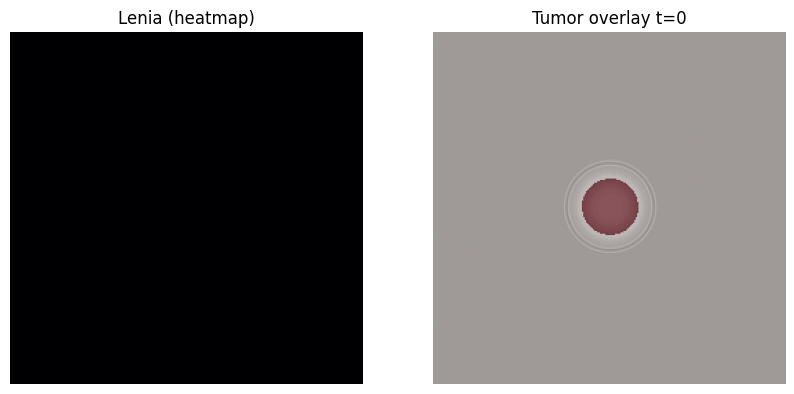

In [5]:
from __future__ import annotations
import numpy as np
from dataclasses import dataclass
from typing import Tuple, Literal, Optional

Array = np.ndarray

# ------------------------------- Kernel Core ---------------------------------

def kernel_core(r: Array, core: Literal['exp', 'poly', 'rect'] = 'exp', alpha: float = 4.0) -> Array:
    """Compute KC(r) for r in [0,1], elementwise.
    Conditions: KC(0)=KC(1)=0, unimodal with peak near 1/2.
    - 'exp' : exp(alpha - alpha/(4 r (1-r))) on (0,1), 0 at endpoints.
    - 'poly': (4 r (1-r))**alpha
    - 'rect': 1 on [1/4, 3/4], else 0
    """
    r = np.asarray(r)
    KC = np.zeros_like(r, dtype=float)

    if core == 'exp':
        # Safe compute on (0,1). At endpoints set to 0.
        mask = (r > 0.0) & (r < 1.0)
        rm = r[mask]
        KC[mask] = np.exp(alpha - (alpha / (4.0 * rm * (1.0 - rm))))
        # Values outside (0,1) remain 0.

    elif core == 'poly':
        KC = np.clip(4.0 * r * (1.0 - r), 0.0, None) ** alpha

    elif core == 'rect':
        KC[(r >= 0.25) & (r <= 0.75)] = 1.0

    else:
        raise ValueError(f"Unknown core type: {core}")
    maxv = KC.max()
    if maxv > 0:
        KC = KC / maxv
    return KC

# ------------------------------- Kernel Shell --------------------------------

def kernel_shell(r: Array, B: int, beta: Array, core: Literal['exp','poly','rect']='exp', alpha: float=4.0) -> Array:
    """
    Compute KS(r; beta) by tiling the core into B bands with heights beta[i].
    r in [0,1]. For each r, i = floor(B*r), phase = B*r - i, KS = beta[i] * KC(phase).
    """
    r = np.asarray(r)
    beta = np.asarray(beta, dtype=float)
    assert len(beta) == B, "beta must have length B"

    # Clamp r into [0,1] and drop outside
    r_clamped = np.clip(r, 0.0, 1.0)

    # Compute band index and local phase within band
    # Use np.minimum to keep the highest index at B-1 when r==1
    idx = np.minimum((np.floor(B * r_clamped)).astype(int), B - 1)
    phase = B * r_clamped - idx
    #since each band spans lenght 1/B , multiplying by B, rescales bandwidth to 1.
    KC = kernel_core(phase, core=core, alpha=alpha)
    KS = beta[idx] * KC
    return KS

# ------------------------------ 2D Kernel Build -------------------------------

def build_kernel(shape: Tuple[int,int], R: float, B: int, beta: Array,
                 core: Literal['exp','poly','rect']='exp', alpha: float=4.0) -> Array:
    """Build a 2D, periodic, normalized kernel K on a torus grid of given shape.

    Parameters
    - shape: (H, W)
    - R: kernel radius in pixels (support is r <= 1 after normalizing by R)
    - B: number of shells (rings)
    - beta: length-B ring amplitudes (will be rescaled implicitly by normalization)

    Returns
    - K: 2D array with sum(K) == 1, centered at (0,0) in FFT sense.
    """
    H, W = shape

    # Construct toroidal coordinate grid with wrap-around distances from origin (0,0)
    y = np.arange(H)
    x = np.arange(W)
    Y, X = np.meshgrid(y, x, indexing='ij')

    # Shortest torus distance to origin along each axis
    dY = np.minimum(Y, H - Y)
    dX = np.minimum(X, W - X)

    # Euclidean radius (pixels), then normalize to r in [0,∞) and later truncate to 1
    rad_pix = np.sqrt(dY**2 + dX**2)
    r = rad_pix / float(R)

    KS = kernel_shell(r, B=B, beta=beta, core=core, alpha=alpha)

    # Truncate outside the unit radius
    KS[r > 1.0] = 0.0

    # Normalize to make sum(K) = 1 (discrete Lenia)
    total = KS.sum()
    if total <= 0:
        raise ValueError("Kernel has zero mass; check R, B, and beta.")
    K = KS / total

    return K

# ----------------------------- Growth / Dynamics ------------------------------

def growth(u: Array, mu: float, sigma: float) -> Array:
    """Standard Lenia growth mapping G(u) in [-1,1], centered at mu with width sigma.
       G(u) = 2 * exp( - (u - mu)^2 / (2 sigma^2) ) - 1
    """
    return 2.0 * np.exp(-0.5 * ((u - mu) / sigma) ** 2) - 1.0

@dataclass
class Lenia:
    shape: Tuple[int,int] = (256, 256)
    R: float = 14.0
    B: int = 3
    beta: Tuple[float,...] = (1.0, 0.5, 0.0)
    mu: float = 0.14
    sigma: float = 0.015
    dt: float = 0.1
    core: Literal['exp','poly','rect'] = 'exp'
    alpha: float = 4.0
    seed: Optional[int] = None

    def __post_init__(self):
        if self.seed is not None:
            rng = np.random.default_rng(self.seed)
        else:
            rng = np.random.default_rng()
        self.rng = rng
        self.A = np.zeros(self.shape, dtype=float)
        self.K = build_kernel(self.shape, self.R, self.B, np.array(self.beta), core=self.core, alpha=self.alpha)
        # Precompute FFT of kernel for fast convolution on torus
        self.K_hat = np.fft.rfft2(self.K)

    # --------------------------- State initialization -------------------------
    def random_init(self, density: float = 0.1, smooth: bool = True) -> None:
        """Seed the grid with random patches in [0,1].
        - density controls sparsity of initial alive regions.
        - smooth applies a brief blur via convolution with the kernel.
        """
        H, W = self.shape
        A = self.rng.random((H, W))
        A = (A < density).astype(float) * self.rng.random((H, W))
        if smooth:
            A = self._convolve(A)
        self.A = np.clip(A, 0.0, 1.0)

    def set_state(self, A: Array) -> None:
        A = np.asarray(A, dtype=float)
        assert A.shape == self.shape
        self.A = np.clip(A, 0.0, 1.0)

    # ------------------------------ Core stepper ------------------------------
    def _convolve(self, A: Array) -> Array:
        return np.fft.irfft2(np.fft.rfft2(A) * self.K_hat, s=self.shape).real

    def step(self, n: int = 1) -> None:
        """Advance the automaton by n Euler steps with clamping to [0,1]."""
        for _ in range(n):
            U = self._convolve(self.A)          # potential in [0,1] (by construction)
            G = growth(U, self.mu, self.sigma)  # in [-1,1]
            self.A = np.clip(self.A + self.dt * G, 0.0, 1.0)

    # ------------------------------ Convenience ------------------------------
    def potential(self) -> Array:
        return self._convolve(self.A)

    def state(self) -> Array:
        return self.A.copy()

# ------------------------------ Tumor utilities ------------------------------
class TumorLenia(Lenia):
    """A thin wrapper around Lenia to treat the single channel as a tumor density field
    in [0,1] and to provide convenience initializers and renderers that look like
    "cells" (blobs) rather than a heatmap.
    """
    def seed_tumor_disk(self, center: Optional[Tuple[int,int]] = None, radius_px: int = 20,
                        amplitude: float = 0.9, noise: float = 0.1) -> None:
        H, W = self.shape
        if center is None:
            center = (H//2, W//2)
        cy, cx = center
        y = np.arange(H)[:,None]
        x = np.arange(W)[None,:]
        # Toroidal shortest distance to center
        dy = np.minimum(np.abs(y - cy), H - np.abs(y - cy))
        dx = np.minimum(np.abs(x - cx), W - np.abs(x - cx))
        r = np.sqrt(dy**2 + dx**2)
        mask = r <= radius_px
        base = np.zeros((H,W), dtype=float)
        base[mask] = amplitude
        if noise > 0:
            base[mask] *= (1.0 - noise) + noise * self.rng.random(np.count_nonzero(mask))
        # Combine with existing state then smooth once
        A = np.clip(self.A + base, 0.0, 1.0)
        self.A = np.clip(self._convolve(A), 0.0, 1.0)

    def render_tumor(self, ax=None, threshold: float = 0.5, overlay_alpha: float = 0.6,
                     show_edges: bool = True):
        """Render the tumor field with a red overlay where A>threshold and optional edges."""
        import matplotlib.pyplot as plt
        A = self.state()
        H, W = A.shape
        if ax is None:
            fig, ax = plt.subplots(figsize=(6,6))
        ax.set_axis_off()
        # Base grayscale
        im = ax.imshow(A, vmin=0.0, vmax=1.0, origin='lower', cmap='gray')
        # Red overlay for super-threshold "cells"
        mask = (A > threshold).astype(float)
        if mask.any():
            ax.imshow(mask, origin='lower', cmap='Reds', vmin=0, vmax=1, alpha=overlay_alpha)
        # Optional crude edges via Laplacian
        if show_edges:
            lap = self._laplacian(A)
            # Normalize edges to [0,1]
            e = np.clip((lap - lap.min()) / (np.ptp(lap) + 1e-8), 0, 1)
            ax.imshow(e, origin='lower', cmap='gray', alpha=0.2)
        return ax

    def _laplacian(self, A: Array) -> Array:
        """Periodic Laplacian via FFT; useful for a soft edge map."""
        H, W = self.shape
        ky = 2*np.pi*np.fft.rfftfreq(W)  # incorrect; we want ky for H and kx for W
        # Proper periodic Laplacian in Fourier space
        ky_full = 2*np.pi*np.fft.fftfreq(H)
        kx_half = 2*np.pi*np.fft.rfftfreq(W)
        KY, KX = np.meshgrid(ky_full, kx_half, indexing='ij')
        k2 = (KX**2 + KY**2)
        Ahat = np.fft.rfft2(A)
        lap_hat = -k2 * Ahat
        return np.fft.irfft2(lap_hat, s=self.shape).real

# --------------------------------- Demo --------------------------------------
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # --- Basic Lenia demo ---
    sim = Lenia(shape=(256, 256), R=14, B=3, beta=(1.0, 0.6, 0.0), mu=0.14, sigma=0.015, dt=0.1,
                core='exp', alpha=4.0, seed=42)
    sim.random_init(density=0.08, smooth=True)

    plt.ion()
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    im0 = ax[0].imshow(sim.state(), vmin=0.0, vmax=1.0, origin='lower', cmap='magma')
    ax[0].set_title("Lenia (heatmap)")
    ax[0].set_axis_off()

    # --- Tumor view demo ---
    tum = TumorLenia(shape=(256,256), R=16, B=3, beta=(1.0, 0.5, 0.2), mu=0.15, sigma=0.02, dt=0.1,
                     core='exp', alpha=4.0, seed=7)
    tum.random_init(density=0.02, smooth=True)
    tum.seed_tumor_disk(center=None, radius_px=24, amplitude=0.95, noise=0.15)
    ax[1].set_title("Tumor overlay (A>0.5 in red)")
    tum.render_tumor(ax=ax[1], threshold=0.5, overlay_alpha=0.65)

    for t in range(600):
        sim.step(1)
        tum.step(1)
        if t % 2 == 0:
            im0.set_data(sim.state())
            ax[1].cla()
            ax[1].set_title(f"Tumor overlay t={t}")
            tum.render_tumor(ax=ax[1], threshold=0.5, overlay_alpha=0.65)
            plt.pause(0.001)

    plt.ioff()
    plt.show()


In [6]:
tum = TumorLenia(shape=(256,256), R=16, B=3, beta=(1.0, 0.5, 0.2),
                 mu=0.15, sigma=0.02, dt=0.1, core='exp', alpha=4.0, seed=7)
tum.random_init(density=0.02, smooth=True)
tum.seed_tumor_disk(center=None, radius_px=24, amplitude=0.95, noise=0.15)

for _ in range(600):
    tum.step()

# Render a frame (matplotlib axes optional)
ax = tum.render_tumor(threshold=0.5, overlay_alpha=0.65, show_edges=True)

A stats: 0.0 1.0 0.12462829934782627


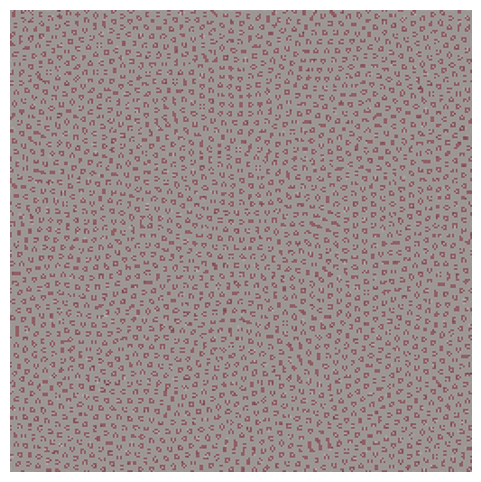

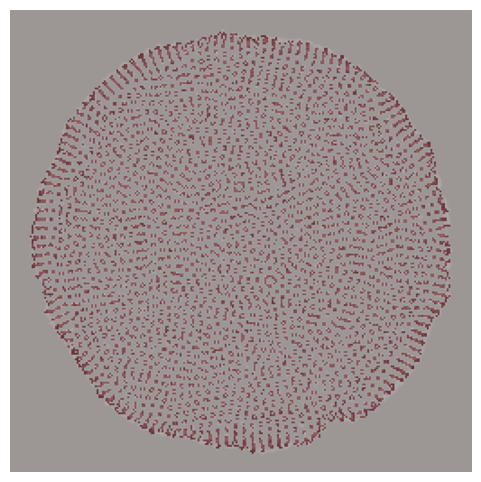

In [7]:
import matplotlib.pyplot as plt

tum = TumorLenia(shape=(256,256), R=14, B=3, beta=(1.0, 0.6, 0.0),
                 mu=0.14, sigma=0.015, dt=0.1, core='exp', alpha=4.0, seed=7)

tum.random_init(density=0.08, smooth=True)                 # denser seed
tum.seed_tumor_disk(radius_px=36, amplitude=0.98, noise=0.1)

for _ in range(400):                                        # fewer steps to avoid extinction
    tum.step()

print("A stats:", tum.state().min(), tum.state().max(), tum.state().mean())

fig, ax = plt.subplots(figsize=(6,6))
tum.render_tumor(ax=ax, threshold=0.3, overlay_alpha=0.65, show_edges=True)  # lower threshold
plt.show()


In [10]:
import numpy as np

tum = TumorLenia(shape=(256,256), R=14, B=3, beta=(1.0, 0.6, 0.0),
                 mu=0.14, sigma=0.015, dt=0.1, core='exp', alpha=4.0, seed=7)

tum.random_init(density=0.08, smooth=True)
tum.seed_tumor_disk(radius_px=36, amplitude=0.98, noise=0.1)

masses = []  # list to store total tumor mass

for step in range(4000):
    tum.step()
    total_mass = tum.state().sum()     # integrate A(x,y)
    masses.append(total_mass)


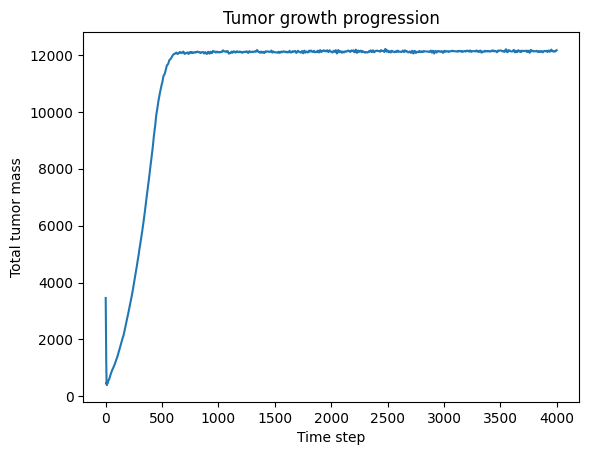

In [11]:
import matplotlib.pyplot as plt

plt.plot(masses)
plt.xlabel("Time step")
plt.ylabel("Total tumor mass")
plt.title("Tumor growth progression")
plt.show()

In [ ]:
# mclenia.py
import numpy as np
from dataclasses import dataclass

# ---- Multi-channel names (order matches your vector A = [AT, AER, APR, AKi67, API3K, AESR1m])
CHANNELS = ["T", "ER", "PR", "Ki67", "PI3K", "ESR1m"]

@dataclass
class ChannelParams:
    # Growth mapping parameters (per channel)
    mu: float = 0.15
    sigma: float = 0.016
    # Kernel shell peaks β (rank = len(beta)); each channel can choose a different β
    beta: tuple = (1.0,)         # rank-1 kernel by default
    # Kernel core "sharpness" for the Gaussian bump used in Lenia kernels
    alpha_core: float = 4.0

@dataclass
class SimParams:
    dt: float = 0.1          # Δt
    steps: int = 1000
    record_every: int = 1    # downsample outputs if you want

# ------------------ Core Lenia pieces (single-channel primitives) ------------------

def kernel_core_gaussian_bump(r, alpha=4.0):
    """KC(r): Unimodal bump with KC(0)=KC(1)=0, KC(0.5)=~1. Matches the 'exponential' core used in Lenia."""
    with np.errstate(divide="ignore", invalid="ignore"):
        z = 4.0 * r * (1.0 - r)
        out = np.exp(alpha - alpha / z)
        out[(r <= 0.0) | (r >= 1.0)] = 0.0
    return out  # ∈ [0,1]

def make_kernel(beta, H, W, alpha_core=4.0):
    """
    Build a Lenia kernel K normalized so that K * A ∈ [0,1], using a concentric shell 'β' (rank = len(beta)).
    FFT version assumes periodic BCs (standard for fast Lenia sims).
    """
    # coordinate grid with origin at center
    yy, xx = np.ogrid[:H, :W]
    cy, cx = (H // 2, W // 2)
    dy = (yy - cy).astype(np.float64)
    dx = (xx - cx).astype(np.float64)
    r = np.sqrt(dx*dx + dy*dy)
    r /= np.max([cx, cy])  # normalize radius ≈ [0, ~1] to map into unit ball

    B = len(beta)
    Br = B * r
    i = np.floor(Br).astype(int)  # which ring
    frac = Br - i                 # local phase inside the ring core
    # clamp index to valid range for shell access
    i = np.clip(i, 0, B - 1)
    shell = np.array(beta, dtype=np.float64)[i]

    core = kernel_core_gaussian_bump(frac, alpha=alpha_core)
    K = shell * core
    K /= K.sum()  # normalize so convolution stays in [0,1] for A ∈ [0,1]
    return K

def growth_map(u, mu, sigma):
    """G(u; μ, σ) = 2 * exp(-(u-μ)^2 / (2σ^2)) - 1  (range ≈ [-1,1])"""
    return 2.0 * np.exp(-((u - mu) ** 2) / (2.0 * sigma ** 2)) - 1.0

# ------------------ Multi-channel engine (no cross-channel coupling) ------------------

class MCLenia:
    def __init__(self, H, W, chan_params):
        """
        chan_params: dict channel_name -> ChannelParams
        """
        self.H, self.W = H, W
        # For each channel, precompute kernel and its FFT
        self.kernels_fft = {}
        self.params = {}
        for ch, p in chan_params.items():
            K = make_kernel(p.beta, H, W, p.alpha_core)
            self.kernels_fft[ch] = np.fft.rfftn(np.fft.ifftshift(K))
            self.params[ch] = p

    def step(self, A_dict, dt):
        """
        A_dict: dict channel_name -> 2D array in [0,1]
        Returns new dict with updated fields + dict of potentials and growths if desired.
        """
        newA = {}
        for ch, A in A_dict.items():
            # FFT-based convolution: U = K * A (periodic)
            A_fft = np.fft.rfftn(A)
            U = np.fft.irfftn(self.kernels_fft[ch] * A_fft, s=A.shape)
            # Growth
            p = self.params[ch]
            G = growth_map(U, p.mu, p.sigma)
            A_next = np.clip(A + dt * G, 0.0, 1.0)
            newA[ch] = A_next
        return newA

    def simulate(self, A0_dict, sim: SimParams, record_means=True):
        """
        Run the simulation from initial fields A0_dict (dict of 2D arrays ∈ [0,1]).
        Returns:
          history  : dict channel -> list of snapshots (every 'record_every' steps)
          means    : dict channel -> np.ndarray of spatial means over *all* steps
        """
        # shallow copies to avoid in-place surprises
        A = {ch: np.array(A0_dict[ch], dtype=np.float64, copy=True) for ch in A0_dict}
        history = {ch: [] for ch in A}
        means = {ch: np.zeros(sim.steps, dtype=np.float64) for ch in A}

        for t in range(sim.steps):
            # record spatial means
            if record_means:
                for ch in A:
                    means[ch][t] = float(A[ch].mean())

            # optionally record snapshots
            if (t % sim.record_every) == 0:
                for ch in A:
                    history[ch].append(A[ch].copy())

            # advance one step (no inter-channel coupling here)
            A = self.step(A, sim.dt)

        return history, means

# ------------------ Convenience: build defaults and run ------------------

def random_blob(H, W, seed=0, density=0.1, blur_sigma=1.5):
    rng = np.random.default_rng(seed)
    X = (rng.random((H, W)) < density).astype(np.float64)
    if blur_sigma > 0:
        # quick-and-dirty Gaussian blur via FFT (not exact, but sufficient to smooth)
        ky = np.fft.fftfreq(H)[:, None]
        kx = np.fft.fftfreq(W)[None, :]
        K2 = np.exp(-2*(np.pi**2)*blur_sigma**2 * (kx*kx + ky*ky))
        X = np.fft.ifft2(np.fft.fft2(X) * K2).real
        X = (X - X.min()) / (X.max() - X.min() + 1e-12)
    return X

if __name__ == "__main__":
    H, W = 256, 256

    # Per-channel kernels (β) & growth parameters — start simple and tweak later.
    # You can give each channel a different kernel “skeleton” (β) and (μ,σ).
    default_params = {
        "T":    ChannelParams(mu=0.15, sigma=0.016, beta=(1.0,)),             # rank-1
        "ER":   ChannelParams(mu=0.15, sigma=0.020, beta=(1.0, 0.0, 0.8)),    # rank-3
        "PR":   ChannelParams(mu=0.15, sigma=0.018, beta=(1.0, 0.5)),         # rank-2
        "Ki67": ChannelParams(mu=0.16, sigma=0.018, beta=(1.0, 0.0, 0.0, 1.0)),
        "PI3K": ChannelParams(mu=0.14, sigma=0.017, beta=(1.0, 0.7, 0.2)),
        "ESR1m":ChannelParams(mu=0.14, sigma=0.019, beta=(1.0,))
    }

    # Initial conditions per channel — independent for now (no coupling).
    A0 = {
        "T":     random_blob(H, W, seed=1, density=0.10, blur_sigma=2.0),
        "ER":    random_blob(H, W, seed=2, density=0.07, blur_sigma=2.0),
        "PR":    random_blob(H, W, seed=3, density=0.07, blur_sigma=2.0),
        "Ki67":  random_blob(H, W, seed=4, density=0.05, blur_sigma=2.0),
        "PI3K":  random_blob(H, W, seed=5, density=0.05, blur_sigma=2.0),
        "ESR1m": random_blob(H, W, seed=6, density=0.04, blur_sigma=2.0),
    }
    # Normalize to [0,1]
    for ch in A0:
        x = A0[ch]
        A0[ch] = np.clip((x - x.min()) / (x.max() - x.min() + 1e-12), 0, 1)

    engine = MCLenia(H, W, default_params)
    sim = SimParams(dt=0.1, steps=2000, record_every=50)

    history, means = engine.simulate(A0, sim, record_means=True)

    # Example: stack means into a (steps, C) array for plotting or ODE-fitting prep
    step_count = sim.steps
    mean_matrix = np.column_stack([means[ch] for ch in CHANNELS if ch in means])
    # Save quick CSV (optional)
    np.savetxt("mc_lenia_means.csv",
               np.column_stack([np.arange(step_count), mean_matrix]),
               delimiter=",",
               header="t," + ",".join([ch for ch in CHANNELS if ch in means]),
               comments="")
    print("Saved spatial means → mc_lenia_means.csv")


C:\Users\User\AppData\Local\Temp\ipykernel_49296\1577758109.py:89: DeprecationWarning: `axes` should not be `None` if `s` is not `None` (Deprecated in NumPy 2.0). In a future version of NumPy, this will raise an error and `s[i]` will correspond to the size along the transformed axis specified by `axes[i]`. To retain current behaviour, pass a sequence [0, ..., k-1] to `axes` for an array of dimension k.
  U = np.fft.irfftn(self.kernels_fft[ch] * A_fft, s=A.shape)


Saved spatial means → mc_lenia_means.csv
